In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
plt.style.use('fivethirtyeight')

from wordcloud import WordCloud, STOPWORDS
from twython import Twython
import settings #twitter keys: APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import string
from collections import defaultdict

import gensim
from gensim import corpora
import sklearn

import requests

C:\Anaconda3\lib\site-packages\gensim\utils.py:843: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
%load_ext watermark
%watermark -d -v -m -p pandas,scipy,matplotlib,twython,nltk,wordCloud,gensim

2017-01-17 

CPython 3.5.1
IPython 4.2.0

pandas 0.18.1
scipy 0.17.1
matplotlib 2.0.0
twython 3.4.0
nltk 3.2.1
wordCloud 1.2.1
gensim 0.13.4

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [10]:
# twython auth
twitter = Twython(settings.APP_KEY, settings.APP_SECRET,settings.OAUTH_TOKEN, settings.OAUTH_TOKEN_SECRET)

In [11]:
#get more than 200 tweets: http://www.craigaddyman.com/mining-all-tweets-with-python/

In [12]:
# init empty lists to save tweets and metadata
user_ids, user_names, texts , creation, retweets ,favorites,lenguage, retweet, retweet_from, in_reply, coordinates = ([] for i in range(11))
# get following IDs and NAMES (can get more info of users if needed!)
following_ids = [] # to save ids
following_names = {} # dictinary key:user_id, value: user_name
user_location = []
following = twitter.get_friends_ids()["ids"]
print("Number of following: ",len(following))

# get 200 tweets and metadata from each friend (can get more metadata if needed!)
for user_id in following:
    tweets200 = twitter.get_user_timeline(user_id=user_id,count=200)
    for t in tweets200:
        user_ids.append(user_id)
        #user_names.append(following_names[user_id])
        texts.append(t["text"])
        creation.append(t["created_at"])
        retweets.append(t["retweet_count"])
        favorites.append(t["favorite_count"])
        lenguage.append(t["lang"])
        #coordinates.append(t["coordinates"])
        in_reply.append(t['in_reply_to_screen_name'])
        retweet.append(('retweeted_status') in t)
        if ('retweeted_status') in t:
            retweet_from.append(t['retweeted_status']['user']['name'])
        else:
            retweet_from.append("N/A")
    #get user location
    user_location.append(twitter.show_user(user_id=user_id)["location"])

TwythonAuthError: Twitter API returned a 400 (Bad Request), Bad Authentication data.

In [6]:
# create final DataFrame
mytweets = pd.DataFrame({'user_id':user_ids,#'user_name':user_names,
                         'text':texts ,'retweet': retweet, 'creation':creation,
                         'retweets':retweets , 'favorites':favorites, 
                         'lenguage':lenguage,'retweet_from': retweet_from,
                         'in_reply':in_reply})

mytweets["in_reply"] = mytweets["in_reply"].map(lambda x: "None" if x is None else x) # fix in_replay column None type to "None"

In [7]:
# checks
print("size:", mytweets.shape, "\n------------------------") #size
print(mytweets.isnull().sum()) #column names $missing values 
print("\nreplies and retweets at the same time:",end=" ")
print(mytweets[(mytweets["in_reply"]!="None") & (mytweets["retweet"]==True)].size)

size: (82659, 9) 
------------------------
creation        0
favorites       0
in_reply        0
lenguage        0
retweet         0
retweet_from    0
retweets        0
text            0
user_id         0
dtype: int64

replies and retweets at the same time: 0


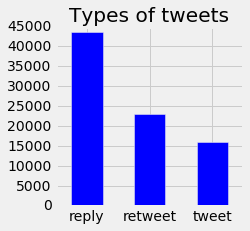

In [8]:
# Home many of all tweets are regular, tweeet, reply
def tweet_type(row):
    if row.retweet == True:
        return "retweet"
    elif row.in_reply == "None":
        return "reply"
    else:
        return "tweet"
# are there any replies and retweets?
a = mytweets.apply(tweet_type,1)
fig=plt.figure(figsize=(3,3))
a.value_counts().plot(kind='bar', color='blue')
plt.title("Types of tweets")
plt.xticks(rotation=0)
plt.show()
del a

In [9]:
mytweets.head()

,creation,favorites,in_reply,lenguage,retweet,retweet_from,retweets,text,user_id
0,Fri Jan 06 16:50:36 +0000 2017,0,None,en,True,Daily Star,11,RT @Daily_Star: Sex star Mia Khalifa most sear...,74466455
1,Fri Jan 06 15:52:05 +0000 2017,140,None,en,False,N/A,31,Alright calm down @Wendys there's only room fo...,74466455
2,Fri Jan 06 15:00:31 +0000 2017,123,None,en,False,N/A,22,Morning!! #reasonstoloveme I give you free porn!,74466455
3,Fri Jan 06 14:29:14 +0000 2017,9,Just_likeLJ,en,False,N/A,1,@Just_likeLJ @BenBerkon @ColCornholeII @realDo...,74466455
4,Fri Jan 06 13:59:37 +0000 2017,0,None,en,True,Gizmodo UK,4,RT @GizmodoUK: This is what UK wankers searche...,74466455


In [10]:
stop = stopwords.words('english') + stopwords.words('spanish')
other_stop = ['via','&amp;', 'now','one','thing','us', 'will',"it's",'it',"i'm","u","you","yet", "say"
             "much", "gt", "new", "us", "also","don't", ]
stop = set(stop + other_stop)
exclude = set(string.punctuation)
def clean_tweets (tweets_string, puntuation=True, lemmatize=False, sentiment=True):
    # gets a string with all tweets and remove RT, links and ids (start with @)
    lemma = WordNetLemmatizer()
    words_clean = " ".join([word.lower() for word in tweets_string.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
    if not sentiment:
        words_clean = " ".join([i for i in words_clean.lower().split() if i not in stop])
    if puntuation:
        words_clean = "".join(ch for ch in words_clean if ch not in exclude)
    if lemmatize :    
            words_clean = " ".join(lemma.lemmatize(word) for word in words_clean.split() if type(word) is str)
    return words_clean
    
# words of ALL TWEETS
words = clean_tweets(' '.join(mytweets['text']), sentiment=False)
# words of ALL REGULAR TWEETS 
words_regular = clean_tweets(' '.join(mytweets[(mytweets["in_reply"]=="None") & (mytweets["retweet"]==False)].text),sentiment=False)
# words of ONLY RETWEETS
words_rt = clean_tweets(' '.join(mytweets[mytweets["retweet"] == True].text),sentiment=False)
# words of ONLY REPLIES
words_reply = clean_tweets(' '.join(mytweets[mytweets["in_reply"] != "None"].text),sentiment=False)

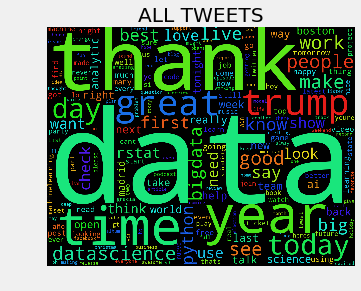

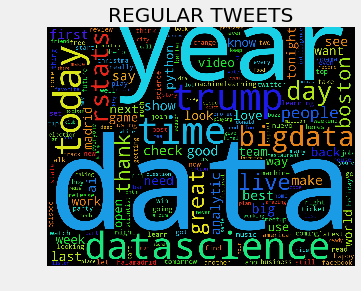

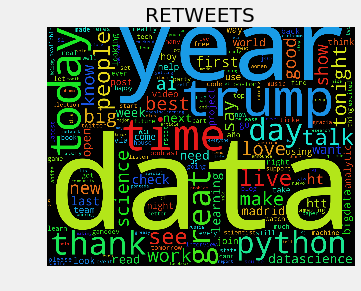

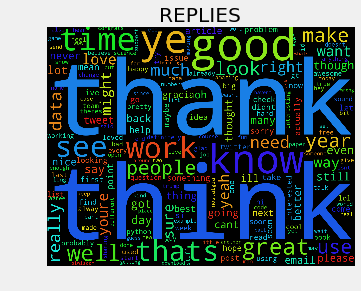

In [11]:
#more_stopwords = {'new', 'amp', 'will', 'yet','via','now','one','thing','us','say','aslo','much','gt'}
#STOPWORDS = STOPWORDS.union(more_stopwords)

# wordcloud 
title = ["ALL TWEETS", "REGULAR TWEETS","RETWEETS","REPLIES"]
i=0 # for plot titles
for data in [words, words_regular, words_rt, words_reply]:  
    #generate wordcloud
    wordcloud = WordCloud(#stopwords=STOPWORDS,
                          background_color='black',
                          width=1800,
                          height=1400
                         ).generate(data)
    #print wordcloud
    plt.imshow(wordcloud)
    plt.title(title[i])
    plt.axis('off')
    plt.show()
    i+=1

In [12]:
def leaders(xs, top=20):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]

# location of followings
locations = leaders(user_location,1000) #all locations

In [13]:
list_add=[] # list of lists [localization, number_of_times, latitude, longitude]

for loc in locations:
    la=[loc[0], loc[1]]
    fix_add = loc[0].replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        coordinates = resp_json_payload['results'][0]['geometry']['location']
        la.append(str(coordinates['lat'])+" "+str(coordinates['lng']))
        list_add.append(la)
    except:
        continue
location_df = pd.DataFrame(list_add, columns=["location","count", "coordinates"])
location_plot = location_df.groupby("coordinates")["count"].sum()
location_plot.sort_values(inplace=True)

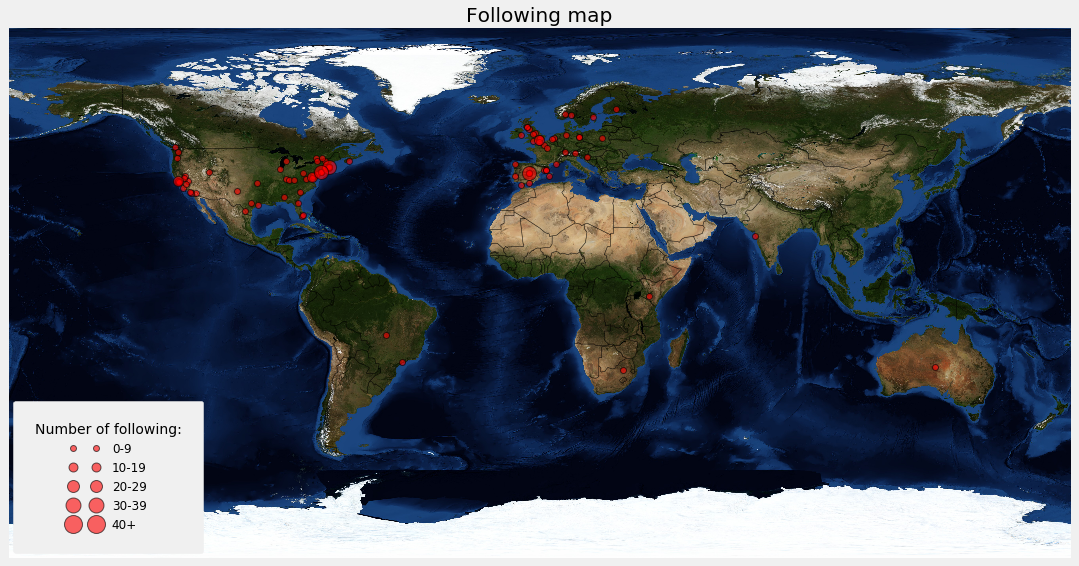

In [14]:
#map
fig = plt.figure(figsize=(17,22))
m = Basemap()
m.bluemarble() #m.etopo()
m.drawcountries()

# cities
marker_size = [6,10,14,19,24]

for loc in location_plot.index:
    lat = loc.split()[0]
    lon = loc.split()[1]
    # bin 5 for clusters
    count = int(location_plot.loc[loc]/10)
    if count > 4: count=4
    m.plot(lon,lat,'bo',markersize=marker_size[count], color='red',alpha=0.6,markeredgecolor='black',
         markeredgewidth=1) 

labels = ['0-9', '10-19', '20-29', '30-39', '40+']

leg = plt.legend(labels, ncol=1,fontsize=12, handlelength=2.5, loc="lower left",
                 borderpad = 1.8,handletextpad=1, title='Number of following:', scatterpoints = 1)
leg.legendHandles[0]._legmarker.set_markersize(6)
leg.legendHandles[1]._legmarker.set_markersize(9)
leg.legendHandles[2]._legmarker.set_markersize(12)
leg.legendHandles[3]._legmarker.set_markersize(15)
leg.legendHandles[4]._legmarker.set_markersize(18)


plt.title("Following map")
plt.show()

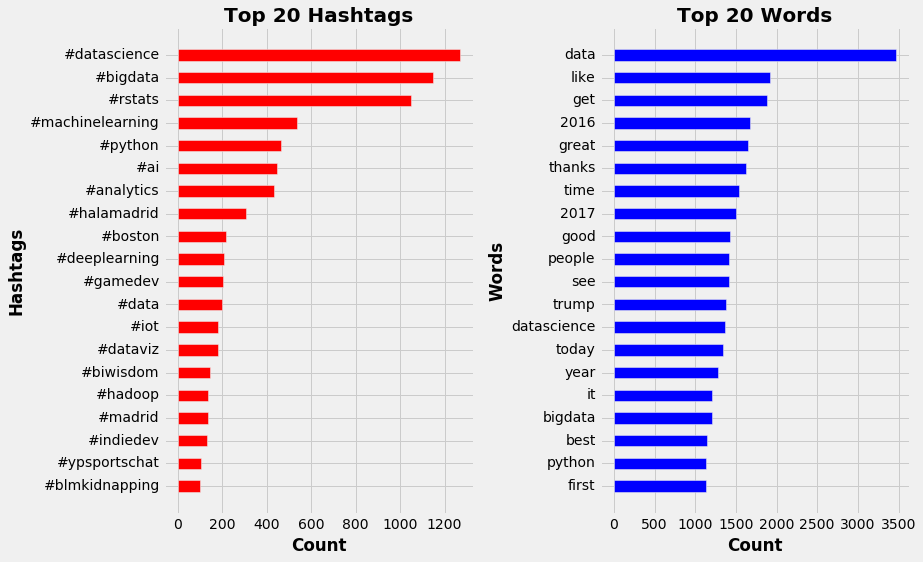

In [15]:
# hastags
words = clean_tweets(' '.join(mytweets['text']), puntuation=False,sentiment=False) # puntuation is False so we don't delete hastags
top10hash = pd.DataFrame(leaders([x for x in words.split() if x[0]=='#' and x!='#rt']),columns=["hashtag", "count"])
#words
words = clean_tweets(' '.join(mytweets['text']),sentiment=False) # puntuation is False so we don't delete hastags
top10words = pd.DataFrame(leaders([x for x in words.split()]), columns=["word", "count"])

fig = plt.figure(figsize=(13,8))
# hashtags barh plot
bar_heights =  top10hash['count'].values
bar_positions = np.arange(len(bar_heights))  
tick_positions = range(0,20) 

ax1 = fig.add_subplot(1,2,1)
ax1.barh(bar_positions, bar_heights, 0.5, align='center', color='red')
ax1.set_yticks(tick_positions)
ax1.set_yticklabels(top10hash['hashtag'].values,)
ax1.set_yticks(tick_positions)
ax1.set_xlabel("Count",fontweight = 'bold')
ax1.set_ylabel("Hashtags",fontweight = 'bold')
ax1.set_title("Top 20 Hashtags",fontweight = 'bold', size=20)
plt.gca().invert_yaxis()
plt.margins(0.05)

#words barh plot
bar_heights =  top10words['count'].values
bar_positions = np.arange(len(bar_heights))  
tick_positions = range(0,20) 

ax2 = fig.add_subplot(1,2,2)
ax2.barh(bar_positions, bar_heights, 0.5, align='center', color='blue')
ax2.set_yticks(tick_positions)
ax2.set_yticklabels(top10words['word'].values,)
ax2.set_yticks(tick_positions)
ax2.set_xlabel("Count",fontweight = 'bold')
ax2.set_ylabel("Words",fontweight = 'bold')
ax2.set_title("Top 20 Words",fontweight = 'bold', size=20 )
plt.gca().invert_yaxis()
plt.margins(0.05)

plt.tight_layout()
plt.show()

In [17]:
from sklearn import cross_validation
from sklearn.feature_extraction.text import CountVectorizer

sa_train = pd.read_csv(".\\data\\Sentiment Analysis Dataset.csv",error_bad_lines=False)
x_sa = sa_train["SentimentText"]
y_sa = sa_train["Sentiment"]
del sa_train
x_sa_clean = x_sa.map(clean_tweets)
# vectorize (bag of words)
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(x_sa)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y_sa, test_size=0.33, random_state=33)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline, grid_search

lge = LogisticRegression(random_state=23, fit_intercept=True)
param_grid = {'C': [0.7,0.5],'class_weight':['balanced']}
lgef = grid_search.GridSearchCV(estimator = lge, param_grid = param_grid, cv = 4, n_jobs=-1, scoring='roc_auc', error_score=0, verbose=2)
lgef.fit(X_train,y_train)
print("Best parameters found by grid search:")
print(lgef.best_params_)
print("Best CV score:")
print(lgef.best_score_)
print(lgef.grid_scores_)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  9.8min finished


Best parameters found by grid search:
{'class_weight': 'balanced', 'C': 0.5}
Best CV score:
0.870732196167
[mean: 0.87027, std: 0.00108, params: {'class_weight': 'balanced', 'C': 0.7}, mean: 0.87073, std: 0.00107, params: {'class_weight': 'balanced', 'C': 0.5}]


Accuracy:  0.799380737203
Precision:  0.791218647998
Recall:  0.814503337139
ROC AUC:  0.799349845072
TPR:  0.814503337139179
FPR:  0.21580364699546048
CONFUSION MATRIX:
TN:  203844    FP:  56096
FN:  48415    TP:  212587


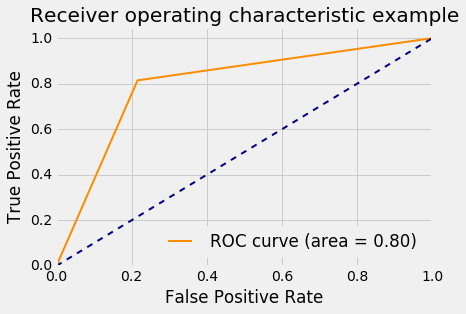

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

predictions = lgef.predict(X_test)
print("Accuracy: ", sklearn.metrics.accuracy_score(y_test, predictions))
print("Precision: ", sklearn.metrics.precision_score(y_test, predictions))
print("Recall: ", sklearn.metrics.recall_score(y_test, predictions))
print("ROC AUC: ", sklearn.metrics.roc_auc_score(y_test, predictions))

predictions = pd.Series(predictions)

tn = len(predictions[(predictions == 0) & (y_test.values==0)])  
tp = len(predictions[(predictions == 1) & (y_test.values==1)]) 
fn = len(predictions[(predictions == 0) & (y_test.values==1)])  
fp = len(predictions[(predictions == 1) & (y_test.values==0)]) 
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(y_test, predictions)
print('CONFUSION MATRIX:')
cm = confusion_matrix(y_test,predictions)
print('TN: ',cm[0,0], '   FP: ',cm[0,1])
print('FN: ',cm[1,0], '   TP: ',cm[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [17]:
from sklearn import cross_validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

sa_train = pd.read_csv(".\\data\\Sentiment Analysis Dataset.csv",error_bad_lines=False)
x_sa = sa_train["SentimentText"]
y_sa = sa_train["Sentiment"]
del sa_train
x_sa_clean = x_sa.map(clean_tweets)
# vectorize (bag of words)
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(x_sa)
# fit the whole training set and pred for my tweets to check
lge = LogisticRegression(random_state=23, fit_intercept=True, C=0.5, class_weight='balanced')
# get Train and my data ready for the molel
x_unseen = vectorizer.transform(mytweets['text'].map(clean_tweets))
lge.fit(X, y_sa)
predictions_unseen = lge.predict(x_unseen)
prob_unseen = lge.predict_proba(x_unseen)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [21]:
results = pd.DataFrame({'Prediction':predictions_unseen,'Prob':list(prob_unseen),'tweet':mytweets['text']})

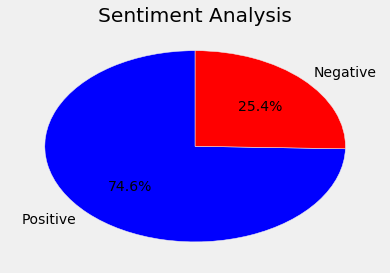

In [41]:
plt.pie(results.Prediction.value_counts(), autopct='%1.1f%%', shadow=False, startangle=90, labels=["Positive","Negative"],colors=["blue","red"])
plt.title("Sentiment Analysis")
plt.show()

In [36]:
results.Prediction.value_counts()

1    61648
0    21011
Name: Prediction, dtype: int64

In [29]:
# checks
for i in range(49000,len(predictions_unseen)):
    print(results.Prediction.iloc[i])
    print(results.Prob.iloc[i])
    print(results.tweet.iloc[i])
    a = input("Press Enter to continue, 'q' to break...")
    if a == 'q':
        break
    else:
        continue
        
# Next steps:
# remove replies. they are too short
# add emoticons to the analyisis, right now they are removed cause I remove puntuation

1
[ 0.20154618  0.79845382]
🌏🏆⚽ #RMCWC

🏅 CAMPEÓN DEL MUNDO
🇪🇸 @nachofi1990

#HalaMadrid https://t.co/VJu8g6daZt
Press Enter to continue, 'q' to break...
1
[ 0.14477807  0.85522193]
👕🏆🌏 #RMCWC
¡Consigue ya tu camiseta con el parche de honor de Campeones del Mundial de Clubes de la FIFA 2016!

👉… https://t.co/eLi0AZBgyU
Press Enter to continue, 'q' to break...
0
[ 0.51414169  0.48585831]
RT @lafabricacrm: IV Memorial en homenaje a Alonso Ezquerra.

https://t.co/TKpBKRNbgt

#RealMadrid #LaFabrica https://t.co/rYwtcKCjda
Press Enter to continue, 'q' to break...
1
[ 0.20154618  0.79845382]
🌏🏆⚽ #RMCWC

🏅 CAMPEÓN DEL MUNDO
🇫🇷 @raphaelvarane

#HalaMadrid https://t.co/OnDl29qMsF
Press Enter to continue, 'q' to break...
1
[ 0.2339319  0.7660681]
🌱🏆🏟 #RMCWC
¡Vive la celebración del Mundial De Clubes en el césped como si fueras un jugador más!

#HalaMadrid https://t.co/zmElI0U2Nj
Press Enter to continue, 'q' to break...
0
[ 0.53802142  0.46197858]
Florentino Pérez presidió la comida de Navidad co

In [ ]:
#LDA
listoft = mytweets['text'].tolist()
list_clean_tweets = [clean_tweets(x,puntuation=True, lemmatize=False) for x in listoft]
doc_clean = [x.split() for x in list_clean_tweets]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)
#results
for i in (ldamodel.print_topics(num_topics=10, num_words=5)):
    print(i)

In [ ]:
#LDA
listoft = mytweets['text'].tolist()
list_clean_tweets = [clean_tweets(x,puntuation=True, lemmatize=True) for x in listoft]
doc_clean = [x.split() for x in list_clean_tweets]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [ ]:
#results
for i in (ldamodel.print_topics(num_topics=10, num_words=3)):
    print(i)